## Growth in a test tube
This simple example illustrates the basic workflow of COMETS, including how to build the simulation layout, to specify parameters, load the model and plot the data once the simulation is finished.

The core of the COMETS methodology is the Dynamic Flux Balance Analysis algorithm (Madahevan et al 2002). One of the first successful simulations of the time dynamics of bacterial metabolism was the classical study of *Escherichia coli* batch culture by Varma and Palsson (1994). Here, we reproduce one of the results in that study, the anaerobic fermentation in minimal media with glucose as the only carbon source.

We will simulate a test tube by setting a well-mixed virtual container with $1cm3$ of media, which we will inoculate with $5\times10^{−6}$ grams of E. coli biomass. We will set the initial composition of the substrate to 11mM of glucose and unlimited amounts of ammonia and phosphate. For the nutrient uptake, we will use standard Michaelis-Menten kinetics, using the experimentally measured Monod parameter for anaerobic uptake of glucose by E. coli.

For this simple example, we use the rudimentary "core" model of E. coli (Orth et al. 2009), which can be downloaded from http://bigg.ucsd.edu/models/e_coli_core or loaded, as we do here, using a function built in CobraPy. This model represents an E. coli metabolism simplified to its core functions (glycolysis, tricarboxylic cycle, pentose phosphate shunt, etc).


### Loading the COMETS Python Toolbox

We first import the COMETS Python toolbox, which will also load all the dependencies, such as CobraPy or pandas.

In [1]:
import cometspy as c
import cobra
import matplotlib.pyplot as plt

### Creating a test tube

We are now ready to create a "layout" for our simulation. By instantiating the class layout without arguments, we will create the default simulation layout, represents an empty, well mixed space (called "cell") with volume 1cm^3. We can then modify this layout according to our needs, in this case adding the media composition in the desired concentration.

In [2]:
# Create empty 1x1 layout
test_tube = c.layout()

# Add 11mM glucose and remove o2
test_tube.set_specific_metabolite('glc__D_e', 0.0372)  #same amount as integrated starting glucose in 2D 6well 
test_tube.set_specific_metabolite('o2_e', 1000)

# Add the rest of nutrients unlimited (ammonia, phosphate, water and protons)
test_tube.set_specific_metabolite('nh4_e',1000);
test_tube.set_specific_metabolite('pi_e',1000);
test_tube.set_specific_metabolite('h2o_e',1000);
test_tube.set_specific_metabolite('h_e',1000);

building empty layout model
models will need to be added with layout.add_model()


### Loading a model

Next, we have to load the model and add it to the layout (or "inoculate it in our test tube").

We will instantiate the comets model class using a loaded CobraPy model as input.

Note that we remove the bounds on glucose import, which will be set dynamically by COMETS during the simulation according to the dynamically changing external glucose concentration. We will set the initial biomass of our model at $10^{-6}$ grams.

In [3]:
# create the model using CobraPy functionality
e_coli_cobra = cobra.io.load_model('textbook')

# use the loaded model to build a comets model
e_coli = c.model(e_coli_cobra)

# remove the bounds from glucose import (will be set dynamically by COMETS)
e_coli.change_bounds('EX_glc__D_e', -1000, 1000)
e_coli.change_bounds('EX_ac_e', -1000, 1000)
e_coli.change_bounds('ATPM', 0, 1000)

e_coli.neutral_drift_flag = True
e_coli.add_neutral_drift_parameter(0.0001)

# set the model's initial biomass
e_coli.initial_pop = [0, 0, 5e-6]

# add it to the test_tube
test_tube.add_model(e_coli)

### Setting the simulation parameters

We next instantiate the params class, which generates a set of parameters for the COMETS simulation with the [TODO LINK TO DEF VALS] default values for all of them. All of the parameters are contained in the all_params field which is a Python dict object, making it easy to change the value of the desired parameters.

In [4]:
# Set the parameters that are different from the default
sim_params = c.params()

In [5]:
sim_params.set_param('defaultVmax', 10)
sim_params.set_param('defaultKm', 0.000015)
sim_params.set_param('maxCycles', 500)
sim_params.set_param('timeStep', 0.05)
sim_params.set_param('spaceWidth', 2.1633) #The concentration in 6well layout is 0.3 mmoll/cm^3 
sim_params.set_param('maxSpaceBiomass', 10)
sim_params.set_param('minSpaceBiomass', 1e-11)
sim_params.set_param('writeMediaLog', True)
sim_params.set_param('mediaLogName', 'media_maint')


### Running the simulation

With all set up, we can now instantiate the comets class by passing the layout (containing the model) and the params objects we just created.

In [6]:
experiment = c.comets(test_tube, sim_params)
#experiment.JAVA_CLASSPATH = '/home/djordje/Dropbox/COMETS_RUN/lib/jmatio.jar:/home/djordje/Dropbox/COMETS_RUN/lib/jdistlib-0.4.5-bin.jar:/home/djordje/Dropbox/COMETS_RUN/lib/commons-math3-3.6.1.jar:/home/djordje/Dropbox/COMETS_RUN/lib/commons-lang3-3.9.jar:/home/djordje/Dropbox/COMETS_RUN/lib/colt.jar:/home/djordje/Dropbox/COMETS_RUN/lib/concurrent.jar:/home/djordje/Dropbox/COMETS_RUN/bin/comets_2.9.3.jar:/opt/gurobi901/linux64/lib/gurobi.jar'

Finally, we can run the simulation as:

In [7]:
experiment.run()


Running COMETS simulation ...
Done!


### Analyzing the results

The results of our simulation are stored in several pandas data frames contained in the comets object that we just simulated. The growth of the simulated model can be seen by plotting the total_biomass field.

(0.0, 0.004)

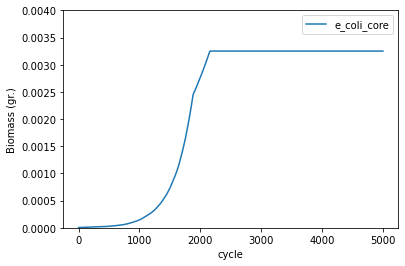

In [11]:
ax = experiment.total_biomass.plot(x = 'cycle')
ax.set_ylabel("Biomass (gr.)")
ax.set_ylim([0,0.004])


Similarly, we can plot composition of the media. In this case, we will limit the plot to those components that are not added to the layout in unlimited amounts (“static” compounds, e.g. ammonia, phosphate, water, etc in this simulation). In this case, we do this by limiting the plot to compounds with concentration lower than 900mM.

(0.0, 0.05)

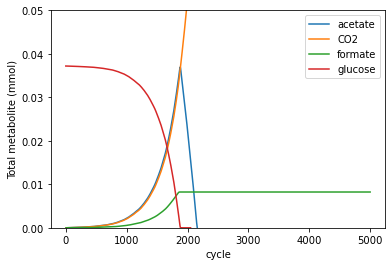

In [13]:
media = experiment.media.copy()
media = media[media.conc_mmol<900]

fig, ax = plt.subplots()
media.groupby('metabolite').plot(x='cycle', ax =ax, y='conc_mmol')
ax.legend(('acetate','CO2', 'formate', 'glucose'))
ax.set_ylabel("Total metabolite (mmol)")
ax.set_ylim([0,0.05])

In [10]:
media[media.cycle==5]

,metabolite,cycle,x,y,conc_mmol
6,ac_e,5,1,1,0.000004
7,co2_e,5,1,1,0.000004
8,for_e,5,1,1,0.000001
9,glc__D_e,5,1,1,0.037196
